In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import pathos.multiprocessing as mp
import copy
import time

class SKMeans(object):
    
    def __init__(self, data, k_max, percent_subsampling, number_of_subsamples):
        self.data = data
        self.k_max = k_max
        self.percent_subsampling = percent_subsampling
        self.number_of_subsamples = number_of_subsamples
        self.scores = scores = dict((k,copy.deepcopy([])) for k in range(2,k_max))
        
    def fit(self, n_jobs = 1, verbose = True):
        pool = mp.ProcessingPool(processes=n_jobs)
        for k in range(2,self.k_max):
            t = time.time()
            for iteration in range(max(int(self.number_of_subsamples/n_jobs), 1)):
                # max becasuse if number of subsamples is smaller than jobs all will be 0
                #the fact that not everyprocess is entering its own score might be a bottle neck
                
                self.scores[k].extend(pool.map(self._loop,[k for i in range(n_jobs)]))

            if verbose:
                print "K={0} done in {1:.10f} seconds \n".format(k,time.time()-t)
                
    
    def _loop(self,k):
        subsample_1 = self.subsample()
        subsample_2 = self.subsample()

        C = self.intersect(subsample_1,subsample_2)

        labels_1 = self.cluster(subsample_1, k)
        labels_2 = self.cluster(subsample_2, k)

        common_labels_1, common_labels_2 = self.find_common_elements(C, labels_1, labels_2)

        labels_score_1 = self.intersect_labels(common_labels_1)
        labels_score_2 = self.intersect_labels(common_labels_2)

        score = self.do_cosine(labels_score_1, labels_score_2)

        #self.scores[k].append(score)
        return score
    
    
    def subsample(self):
        """First call this, Input: data and percent to subsample, returns random subsample"""
        random_indices = np.random.randint(0,len(self.data), int(self.percent_subsampling*len(self.data)))
        return self.data[random_indices]


    def cluster(self, X, k):
        """Second run this, Clusters X into K clusters and returns their labels"""
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        return kmeans.labels_


    #Tested works
    def intersect(self, subsample_1 , subsample_2):
        """Second you can also run this, finds the interesction of two subsamples, tested and works.
           Input: Intersections, returns, a binary matrix, one where the element with index of subsample_1 on each row is the same
           as the element with index of subsample_2 on each column"""

        assert np.shape(subsample_1)==np.shape(subsample_2), 'subsamples have different shapes'
        C = np.zeros(shape=(np.shape(subsample_1)[0],np.shape(subsample_1)[0]))
        for i,s1 in enumerate(subsample_1):
            for j,s2 in enumerate(subsample_2):
                if np.sum(np.equal(s1,s2))==np.shape(subsample_1)[1]: #This will happen if all the columns are 1 i.e. [True, True, True]
                    C[i][j] = 1
        return C



    def find_common_elements(self, C, labels_1, labels_2):
        """Third: computes two 1-d arrays, each array has indices that will yield the same element, if used to query the
        parent subsample, in other words the locations where that element is repeated. Once that is calculated, it will
        return the labels corresponding to each of those elements."""
        #will return rows and columns where C is one, i.e which elements in the parent matrices were together
        here = np.where(C==1)
        #The clustered points will be in the same order because of the here_matrix
        labels_1_ = labels_1[here[0]]
        labeld_2_ = labels_2[here[1]]
        return labels_1_, labeld_2_


    #make a clustered with itself on cluster_1 and cluster_2 and then compute the similarities
    def intersect_labels(self, labels):
        """Fourth: use the labels from find_common_elements here to see who are clustered together"""
        label_score = np.zeros(shape=(len(labels),len(labels)))
        for i, label_i in enumerate(labels):
            for j, label_j in enumerate(labels):
                if label_i == label_j:
                    if i!=j:
                        label_score[i][j] = 1
        return label_score



    def do_cosine(self, intersect_labels_1, intersect_labels_2):
        numerator = np.sum(np.multiply(intersect_labels_1, intersect_labels_2))
        denominator = np.sum(np.multiply(
                                         intersect_labels_1,
                                         intersect_labels_1))*np.sum(np.multiply(intersect_labels_2,
                                                                                 intersect_labels_2))
        return numerator/(denominator)**0.5


In [2]:
from sklearn import datasets

In [3]:
data = datasets.make_blobs(n_samples=500,n_features=2,centers=5,random_state=45)

In [4]:
skmeans = SKMeans(data[0], 10,.7,10)

In [5]:
skmeans.fit(n_jobs=3)

K=2 done in 5.0043990612 seconds 

K=3 done in 5.6178939342 seconds 

K=4 done in 5.7945759296 seconds 

K=5 done in 6.0803191662 seconds 

K=6 done in 6.1507592201 seconds 

K=7 done in 6.2971701622 seconds 

K=8 done in 7.0747268200 seconds 

K=9 done in 7.9579489231 seconds 



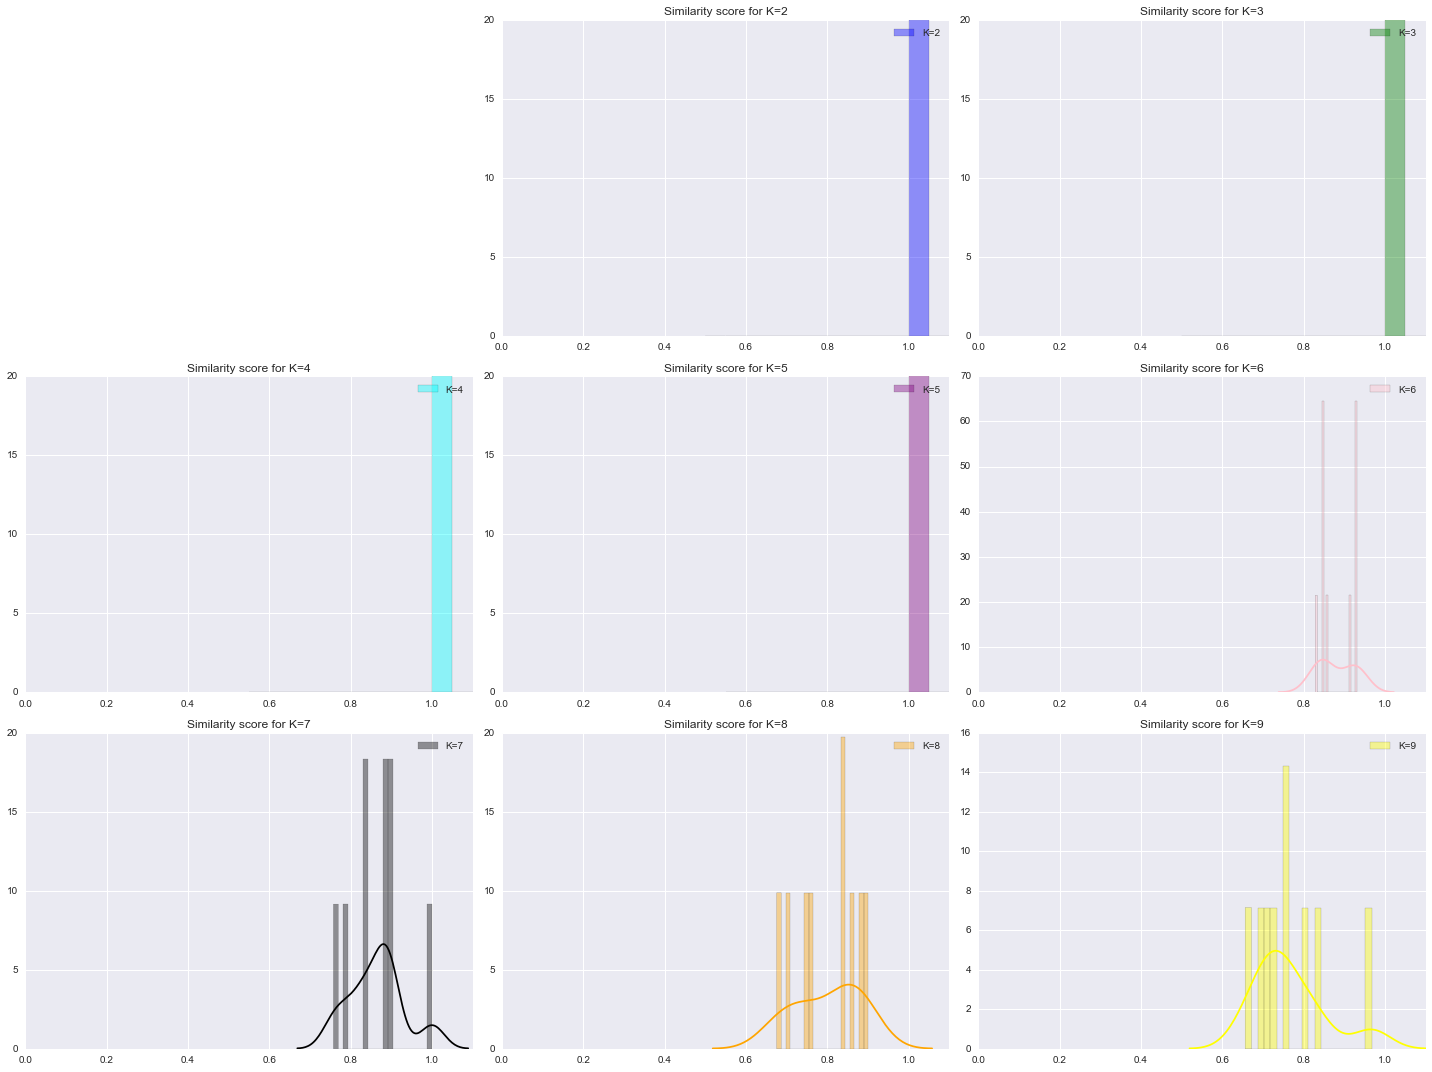

In [6]:
import seaborn as sns
%matplotlib inline
colors = ['red','blue','green','cyan','purple','pink','black','orange','yellow']
scores = skmeans.scores
plt.figure(figsize=(20,15))
for entry in scores:
    if scores[entry]!=[]:
        plt.subplot(3,3,entry)
        plt.title('Similarity score for K={0}'.format(entry))
        sns.distplot(scores[entry], label="K={0}".format(entry), color= colors[entry-1], bins=20)
        plt.xlim(0,1.1)
        plt.legend()
        plt.tight_layout()

In [84]:
skmeans.scores

{2: [0.71926109422041984, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0],
 6: [1.0, 0.80893097349783227, 0.96641477873063586, 0.95317185510581115],
 7: [0.86471551610745778,
  0.98630072272418956,
  0.79650118406407555,
  0.96076892283052284],
 8: [0.97958968940876445,
  0.7970811413304556,
  0.69985439623706958,
  0.87759555439954284],
 9: [0.90385911649576833,
  0.95442714446366661,
  0.86346702986838597,
  0.85459156164195571]}